In [1]:
using ITensors
using PyCall
using Plots
using Random, Distributions
using DelimitedFiles
using StatsBase

# Creating Number States in ITensor

In [2]:
sites = siteinds("Qudit", 10; dim=10);

In [3]:
mps = randomMPS(sites; linkdims=4)

MPS
[1] ((dim=10|id=546|"Qudit,Site,n=1"), (dim=4|id=819|"Link,l=1"))
[2] ((dim=4|id=819|"Link,l=1"), (dim=10|id=513|"Qudit,Site,n=2"), (dim=4|id=120|"Link,l=2"))
[3] ((dim=4|id=120|"Link,l=2"), (dim=10|id=724|"Qudit,Site,n=3"), (dim=4|id=915|"Link,l=3"))
[4] ((dim=4|id=915|"Link,l=3"), (dim=10|id=966|"Qudit,Site,n=4"), (dim=4|id=592|"Link,l=4"))
[5] ((dim=4|id=592|"Link,l=4"), (dim=10|id=529|"Qudit,Site,n=5"), (dim=4|id=685|"Link,l=5"))
[6] ((dim=4|id=685|"Link,l=5"), (dim=10|id=360|"Qudit,Site,n=6"), (dim=4|id=853|"Link,l=6"))
[7] ((dim=4|id=853|"Link,l=6"), (dim=10|id=187|"Qudit,Site,n=7"), (dim=4|id=585|"Link,l=7"))
[8] ((dim=4|id=585|"Link,l=7"), (dim=10|id=78|"Qudit,Site,n=8"), (dim=4|id=64|"Link,l=8"))
[9] ((dim=4|id=64|"Link,l=8"), (dim=10|id=6|"Qudit,Site,n=9"), (dim=4|id=150|"Link,l=9"))
[10] ((dim=4|id=150|"Link,l=9"), (dim=10|id=876|"Qudit,Site,n=10"))


In [4]:
mps2 = randomMPS(sites; linkdims=4)

MPS
[1] ((dim=10|id=446|"Qudit,Site,n=1"), (dim=4|id=496|"Link,l=1"))
[2] ((dim=4|id=496|"Link,l=1"), (dim=10|id=650|"Qudit,Site,n=2"), (dim=4|id=827|"Link,l=2"))
[3] ((dim=4|id=827|"Link,l=2"), (dim=10|id=633|"Qudit,Site,n=3"), (dim=4|id=303|"Link,l=3"))
[4] ((dim=4|id=303|"Link,l=3"), (dim=10|id=967|"Qudit,Site,n=4"), (dim=4|id=125|"Link,l=4"))
[5] ((dim=4|id=125|"Link,l=4"), (dim=10|id=497|"Qudit,Site,n=5"), (dim=4|id=901|"Link,l=5"))
[6] ((dim=4|id=901|"Link,l=5"), (dim=10|id=726|"Qudit,Site,n=6"), (dim=4|id=401|"Link,l=6"))
[7] ((dim=4|id=401|"Link,l=6"), (dim=10|id=302|"Qudit,Site,n=7"), (dim=4|id=895|"Link,l=7"))
[8] ((dim=4|id=895|"Link,l=7"), (dim=10|id=181|"Qudit,Site,n=8"), (dim=4|id=195|"Link,l=8"))
[9] ((dim=4|id=195|"Link,l=8"), (dim=10|id=368|"Qudit,Site,n=9"), (dim=4|id=551|"Link,l=9"))
[10] ((dim=4|id=551|"Link,l=9"), (dim=10|id=309|"Qudit,Site,n=10"))


# Try PyCall with SaX

In [5]:
pyts = pyimport("pyts.approximation")
X = randn(3, 100);

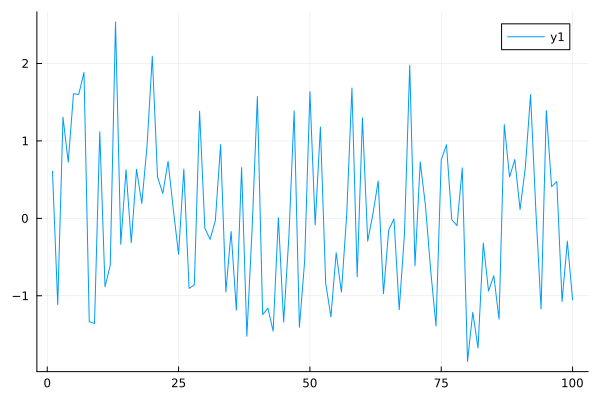

In [6]:
plot(X[1, :])

In [7]:
n_bins = 5
sax = pyts.SymbolicAggregateApproximation(n_bins=n_bins, strategy="normal")
X_sax = sax.fit_transform(X);
X_sax[1][80]

"a"

In [222]:
sax.fit(X)

PyObject SymbolicAggregateApproximation(n_bins=5, strategy='normal')

In [8]:
sites = siteinds("Qudit", 100; dim=n_bins);

Map this test series into a product state

In [9]:
X_sax[1][1]

"d"

In [10]:
mapping = Dict(
    "a" => 1,
    "b" => 2, 
    "c" => 3,
    "d" => 4,
    "e" => 5
)

Dict{String, Int64} with 5 entries:
  "c" => 3
  "e" => 5
  "b" => 2
  "a" => 1
  "d" => 4

In [11]:
letter = "a"
mapping[letter]

1

In [12]:
function SaxToEncoding(sax_sample, sites)
    mapping = Dict(
        "a" => 1,
        "b" => 2, 
        "c" => 3,
        "d" => 4,
        "e" => 5
    )
    product_state = MPS(sites; linkdims=1)
    for j=1:length(sites)
        T = ITensor(sites[j])
        letter = sax_sample[j]
        T[mapping[letter]] = 1
        product_state[j] = T
    end
    return product_state
end;

In [13]:
ps_1 = SaxToEncoding(X_sax[1], sites)
ps_2 = SaxToEncoding(X_sax[2], sites)
ps_3 = SaxToEncoding(X_sax[3], sites);

Compute inner product between two product states with the SaX encodings. 

In [14]:
inner(ps_1, ps_2)

0

Make random MPS to do an inner product with

In [18]:
ψ = randomMPS(sites; linkdims=5);

# Now try with ECG200 Data

In [19]:
ecg_dat = readdlm("../ECG200_TRAIN.txt")
X_train = ecg_dat[:, 2:end]
y_train = Int.(ecg_dat[:, 1])
remap = Dict(-1 => 0, 1 => 1)
y_train = [remap[label] for label in y_train];
y_train = reshape(y_train, length(y_train), 1);

# Z normalise Data First

In [20]:
scaler = fit(ZScoreTransform, X_train, dims=1)
X_train_normalised = StatsBase.transform(scaler, X_train)

100×96 Matrix{Float64}:
 -0.34773    -0.948292  -1.2578     …   0.634284    0.856707    0.625904
 -0.944867   -0.665411  -1.59653       -0.369631   -2.33609    -0.925646
 -0.660123   -1.27046   -1.59395        0.700151    1.02487     0.881154
  0.775782    0.704493  -0.266514       1.46358     0.996416    1.34579
 -0.100722   -0.722139   0.570344      -1.10799     0.212586    0.984727
 -0.511707   -0.152259   0.454683   …  -0.119282    0.264819    0.397254
  0.83666     0.657029   0.389868       0.0961123   0.554286    0.128194
 -0.185668   -0.348526  -0.339696      -0.223267    0.182835   -0.270598
 -0.640979   -0.228379   0.533494      -0.42334     0.0724248   0.156769
  1.6171      1.53671    0.456431      -0.746629   -0.20458    -0.0652107
  ⋮                                 ⋱                           ⋮
  0.0454918   0.482584   0.189788       0.302289    0.416405    0.291401
 -0.494392   -0.806569  -0.114667      -1.05587    -0.702982   -0.489293
 -0.457221   -1.33561   -2.31901  

Plot an example time series before and after Z-scoring

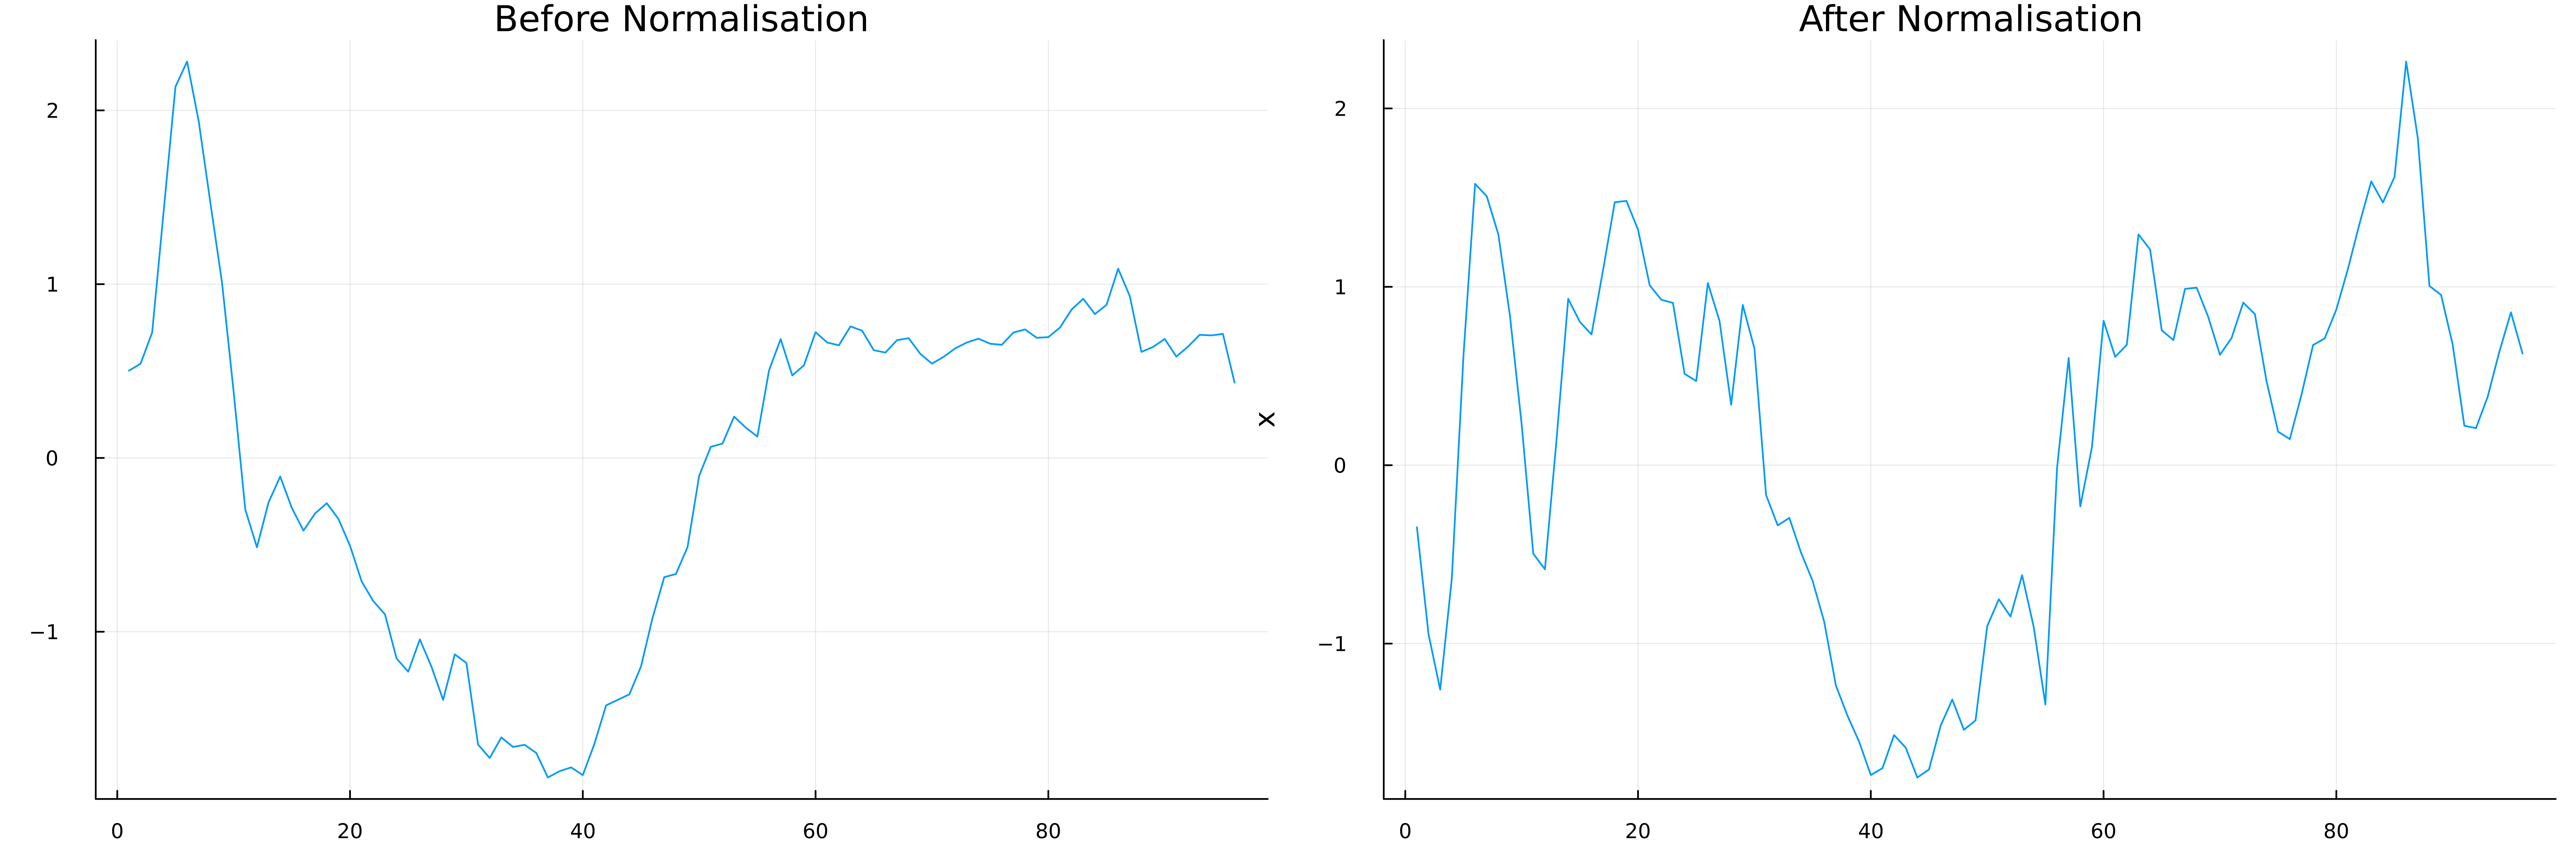

In [21]:
p1 = plot(X_train[1,:], label="", dpi=800)
title!("Before Normalisation")
xlabel!("Time")
ylabel!("x")
p2 = plot(X_train_normalised[1,:], label="")
xlabel!("Time")
ylabel!("x")
title!("After Normalisation")
plot(p1, p2, size=(1500,500))
#savefig("before_after_norm_TS.png")

Apply SaX

In [22]:
n_bins = 5
sax = pyts.SymbolicAggregateApproximation(n_bins=n_bins, strategy="normal") # strategy = gaussian bins
X_sax = sax.fit_transform(X_train_normalised);

In [23]:
X_sax.shape

(100, 96)

In [24]:
ss = pyimport("scipy.stats");
np = pyimport("numpy");

In [25]:
bins = ss.norm.ppf(np.linspace(0, 1, n_bins + 1)[2:end-1]) # compute gaussian bins

4-element Vector{Float64}:
 -0.8416212335729142
 -0.2533471031357997
  0.25334710313580006
  0.8416212335729143

In [26]:
X_sax[1]

PyObject array(['b', 'a', 'a', 'b', 'd', 'e', 'e', 'e', 'd', 'c', 'b', 'b', 'c',
       'e', 'd', 'd', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'd', 'd', 'e',
       'd', 'd', 'e', 'd', 'c', 'b', 'b', 'b', 'b', 'a', 'a', 'a', 'a',
       'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'b', 'a',
       'b', 'a', 'a', 'c', 'd', 'c', 'c', 'd', 'd', 'd', 'e', 'e', 'd',
       'd', 'e', 'e', 'd', 'd', 'd', 'e', 'e', 'd', 'c', 'c', 'd', 'd',
       'd', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'd', 'c',
       'c', 'd', 'd', 'e', 'd'], dtype='<U1')

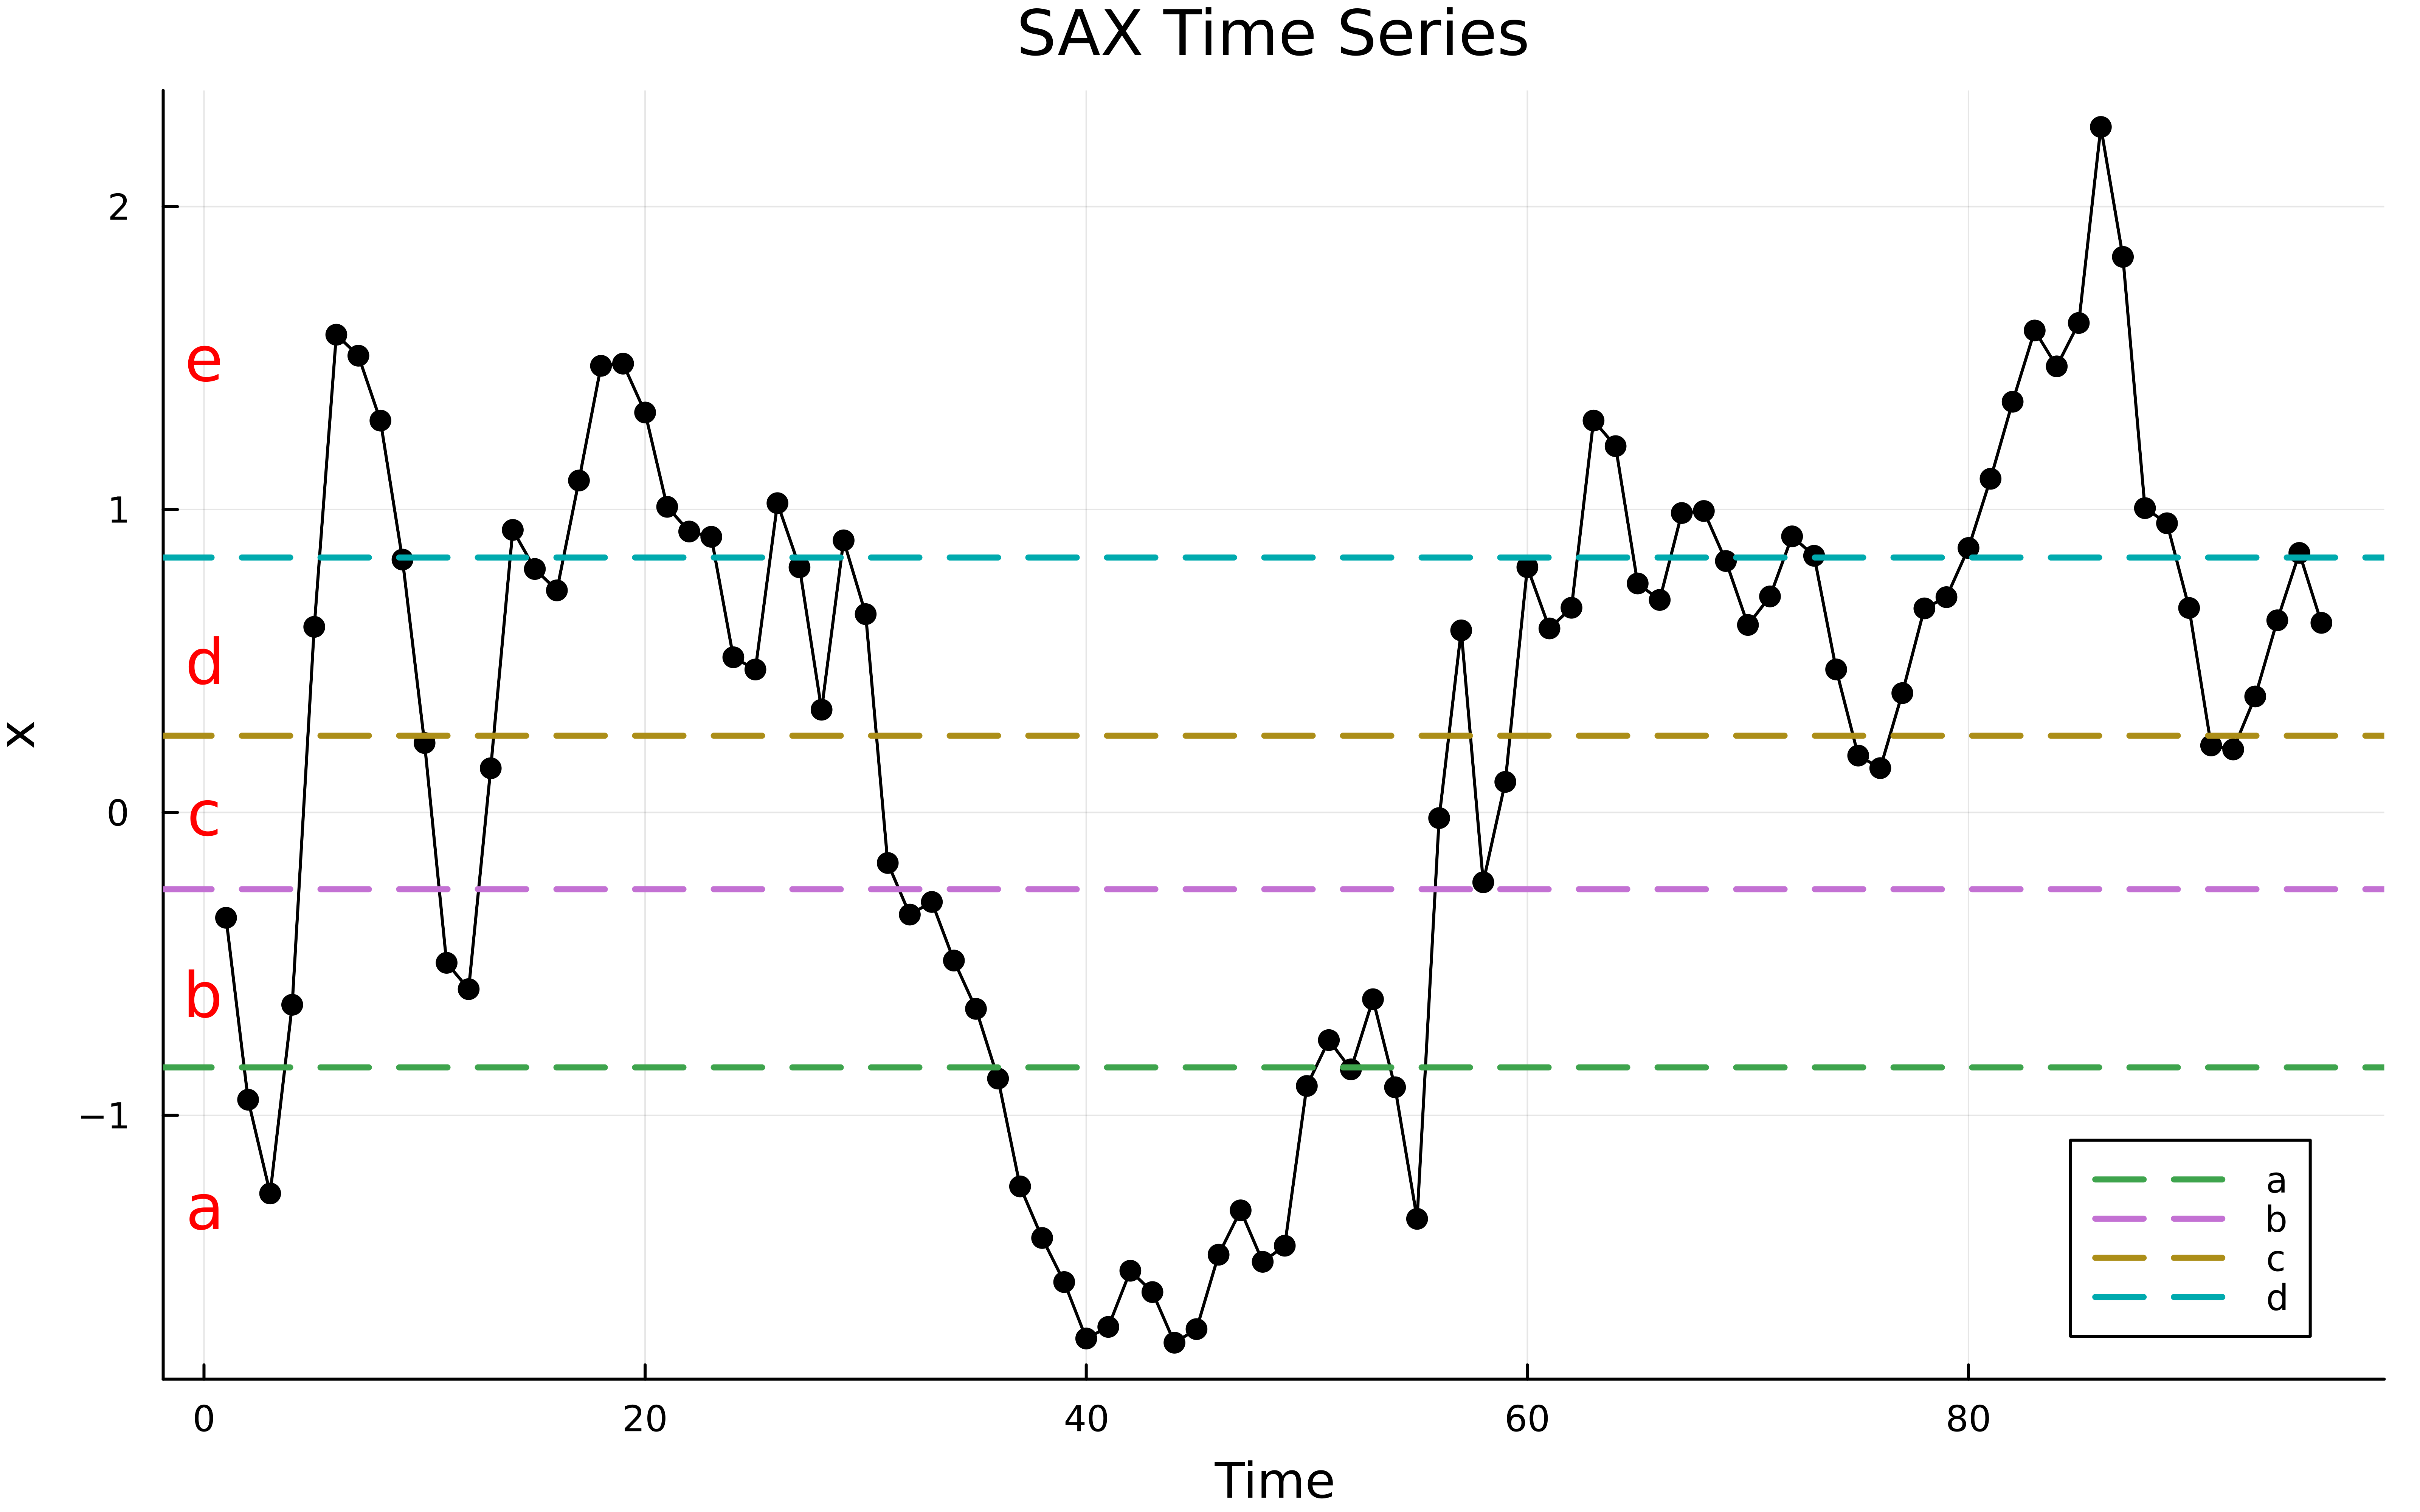

In [87]:
p = scatter(X_train_normalised[1,:],
    size=(800,500),
    label="", 
    c=:black,
    dpi=800)
plot!(X_train_normalised[1,:], size=(800,500), label="", c=:black)
alphabet = ['a', 'b', 'c', 'd', 'e']
for i=1:4
    hline!([bins[i]], label="$(alphabet[i])", ls=:dash, lw=2)
end
title!("SAX Time Series")
xlabel!("Time")
ylabel!("x")
annotate!(0, 1.5, Plots.text("e", :red))
annotate!(0, 0.5, Plots.text("d", :red))
annotate!(0, 0, Plots.text("c", :red))
annotate!(0, -0.6, Plots.text("b", :red))
annotate!(0, -1.3, Plots.text("a", :red))
display(p)
#savefig("sax-time-series-sample.png")

In [79]:
sites = siteinds("Qudit", size(X_train_normalised)[2]; dim=n_bins);

In [92]:
ITensors.dim(sites[1])

5

In [108]:
length(sites)

96

In [130]:
test_list = ["a", "d", "e", "c"]
sort(test_list)


4-element Vector{String}:
 "a"
 "c"
 "d"
 "e"

In [166]:
alphabet = 'a':'z'
alphabet_size = 5
#collect(alphabet[1:5])
dict_store = Dict()
for (i, letter) in enumerate(alphabet[1:alphabet_size])
    #println("$i $letter");
    dict_store[string(letter)] = i
end
#Dict(i - 'a' + 1 => letter for (i, letter) in enumerate(alphabet[1:alphabet_size]))

In [167]:
dict_store

Dict{Any, Any} with 5 entries:
  "c" => 3
  "e" => 5
  "b" => 2
  "a" => 1
  "d" => 4

In [177]:
function SAXEncodingToFock(sax_sample, sites::Vector{Index{Int64}}, sax_encoder)
    """Function to map the SAX encodings to a product state where the 
    local dimension is determined by the alphabet size for SAX.
    Allocate mappings dynamically so that it works for any alphabet size"""
    # first check that the local hilbert dim and the alphabet size match - pass in the sax encoder object as time-series not guarenteeed to contain full alphabet? 
    if sax_encoder.n_bins !== ITensors.dim(sites[1])
        error("Alphabet size ($(sax_encoder.n_bins)) not equal to the local hilbert space dimension ($(ITensors.dim(sites[1]))) specified in site indices.")
    end

    # check that the number of site indices and the length of the SAX-encoded sample match.
    if length(sax_sample) !== length(sites)
        error("Length of the SAX-encoded sample ($(length(sax_sample))) does not match the number of sites specified by the site indices ($(length(sites)))!")
    end

    # dynamically allocate mappings based on alphabet size
    alphabet_size = sax_encoder.n_bins
    alphabet = 'a': 'z'

    # use the following mapping convention with a always mapping to 1, b to 2, so on..
    mappings = Dict()
    for (i, letter) in enumerate(alphabet[1:alphabet_size])
        mappings[string(letter)] = i
    end

    # create empty product state container
    ϕ = MPS(sites; linkdims=1)

    # loop through each site and fill Tensor with fock state
    # by default, each tensor is empty, and assigning 1 to an entry is equiv. to one-hot encoding
    for s=1:length(sites)
        T = ITensor(sites[s])
        letter = sax_sample[s]
        T[mappings[letter]] = 1 # one hot encode, so |a> -> |1> -> [1, 0, 0, ..]
        ϕ[s] = T
    end

    return ϕ

end;


In [174]:
sax

PyObject SymbolicAggregateApproximation(n_bins=5, strategy='normal')

In [191]:
ϕ1 = SAXEncodingToFock(X_sax[2], sites, sax)
ϕ2 = SAXEncodingToFock(X_sax[5], sites, sax)

MPS
[1] ((dim=5|id=368|"Qudit,Site,n=1"),)
[2] ((dim=5|id=603|"Qudit,Site,n=2"),)
[3] ((dim=5|id=200|"Qudit,Site,n=3"),)
[4] ((dim=5|id=967|"Qudit,Site,n=4"),)
[5] ((dim=5|id=587|"Qudit,Site,n=5"),)
[6] ((dim=5|id=298|"Qudit,Site,n=6"),)
[7] ((dim=5|id=569|"Qudit,Site,n=7"),)
[8] ((dim=5|id=544|"Qudit,Site,n=8"),)
[9] ((dim=5|id=66|"Qudit,Site,n=9"),)
[10] ((dim=5|id=176|"Qudit,Site,n=10"),)
[11] ((dim=5|id=150|"Qudit,Site,n=11"),)
[12] ((dim=5|id=68|"Qudit,Site,n=12"),)
[13] ((dim=5|id=263|"Qudit,Site,n=13"),)
[14] ((dim=5|id=208|"Qudit,Site,n=14"),)
[15] ((dim=5|id=195|"Qudit,Site,n=15"),)
[16] ((dim=5|id=395|"Qudit,Site,n=16"),)
[17] ((dim=5|id=457|"Qudit,Site,n=17"),)
[18] ((dim=5|id=700|"Qudit,Site,n=18"),)
[19] ((dim=5|id=859|"Qudit,Site,n=19"),)
[20] ((dim=5|id=803|"Qudit,Site,n=20"),)
[21] ((dim=5|id=214|"Qudit,Site,n=21"),)
[22] ((dim=5|id=174|"Qudit,Site,n=22"),)
[23] ((dim=5|id=325|"Qudit,Site,n=23"),)
[24] ((dim=5|id=915|"Qudit,Site,n=24"),)
[25] ((dim=5|id=173|"Qudit,Site,

# Small scale test

Try with just the first 5 samples of each time-series

In [210]:
W = randomMPS(sites; linkdims=5);

Create & attach a label index

In [213]:
label_idx = Index(2, "f(x)")

(dim=2|id=238|"f(x)")

In [215]:
old_site_inds = inds(W[1])
new_site_inds = old_site_inds, label_idx
new_site = randomITensor(new_site_inds)

ITensor ord=3 (dim=5|id=368|"Qudit,Site,n=1") (dim=5|id=590|"Link,l=1") (dim=2|id=238|"f(x)")
NDTensors.Dense{Float64, Vector{Float64}}

In [216]:
W[1] = new_site

ITensor ord=3 (dim=5|id=368|"Qudit,Site,n=1") (dim=5|id=590|"Link,l=1") (dim=2|id=238|"f(x)")
NDTensors.Dense{Float64, Vector{Float64}}

In [220]:
normalize!(W)

MPS
[1] ((dim=5|id=368|"Qudit,Site,n=1"), (dim=5|id=590|"Link,l=1"), (dim=2|id=238|"f(x)"))
[2] ((dim=5|id=590|"Link,l=1"), (dim=5|id=603|"Qudit,Site,n=2"), (dim=5|id=484|"Link,l=2"))
[3] ((dim=5|id=484|"Link,l=2"), (dim=5|id=200|"Qudit,Site,n=3"), (dim=5|id=361|"Link,l=3"))
[4] ((dim=5|id=361|"Link,l=3"), (dim=5|id=967|"Qudit,Site,n=4"), (dim=5|id=752|"Link,l=4"))
[5] ((dim=5|id=752|"Link,l=4"), (dim=5|id=587|"Qudit,Site,n=5"), (dim=5|id=234|"Link,l=5"))
[6] ((dim=5|id=234|"Link,l=5"), (dim=5|id=298|"Qudit,Site,n=6"), (dim=5|id=282|"Link,l=6"))
[7] ((dim=5|id=282|"Link,l=6"), (dim=5|id=569|"Qudit,Site,n=7"), (dim=5|id=141|"Link,l=7"))
[8] ((dim=5|id=141|"Link,l=7"), (dim=5|id=544|"Qudit,Site,n=8"), (dim=5|id=822|"Link,l=8"))
[9] ((dim=5|id=822|"Link,l=8"), (dim=5|id=66|"Qudit,Site,n=9"), (dim=5|id=649|"Link,l=9"))
[10] ((dim=5|id=649|"Link,l=9"), (dim=5|id=176|"Qudit,Site,n=10"), (dim=5|id=805|"Link,l=10"))
[11] ((dim=5|id=805|"Link,l=10"), (dim=5|id=150|"Qudit,Site,n=11"), (dim=5|id=

# Overlap Test

To get an idea of how the magnitude of the overlap scales with the length of the data, we do a small experiment.

In [7]:
include("/Users/joshua/Documents/QuantumInspiredML/NumberState/NumberStateMPS.jl")

PlotSaxSample (generic function with 1 method)

In [8]:
train_data = rand(100, 10)
labels = rand([0, 1], 100)
val_data = rand(100, 10)
val_labels = rand([0, 1], 100);


In [9]:
W, tstates = fitMPS(train_data, labels, val_data, val_labels; num_sax_bins=5, χ_max=25, α=0.1)

Applying SAX to the training data. Using 5 bins.
